Kelompok Naga 😭😭
- Shafa Diva Syahira - 1301200157 
- Muhammad Fadil Maulana Akbar - 1301204297 
- Alifia Rizqi Adi Winarsasi - 1301204147

### Import Library

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Read Data

In [53]:
df_recipes = pd.read_csv('recipes.csv')
df_reviews = pd.read_csv('reviews.csv')

In [54]:
df_recipes.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


In [55]:
df_reviews.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


### Reviews Pre-processing

In [56]:
df_reviews_filtered = df_reviews[(df_reviews['DateSubmitted'] >= '2000-01-26') & (df_reviews['DateSubmitted'] <= '2001-12-31')]
df_reviews_filtered['DateSubmitted'] = pd.to_datetime(df_reviews_filtered['DateSubmitted'])
df_reviews_filtered = df_reviews_filtered.sort_values(by=['DateSubmitted'])
df_reviews_filtered

/tmp/ipykernel_13189/889195125.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews_filtered['DateSubmitted'] = pd.to_datetime(df_reviews_filtered['DateSubmitted'])


,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25 09:00:00+00:00,2000-02-25T09:00:00Z
8,22,517,2046,Gay Gilmore ckpt,5,thought this was terrific!,2000-02-25 09:02:00+00:00,2000-02-25T09:02:00Z
9,23,4684,2046,Gay Gilmore ckpt,5,this is absolutely delicious. i even served i...,2000-02-25 09:06:00+00:00,2000-02-25T09:06:00Z
10,24,278,1773,Malarkey Test,4,"a little greasy, but a huge hit with the guests.",2000-03-13 19:53:00+00:00,2000-03-13T19:53:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13 21:15:00+00:00,2000-03-13T21:15:00Z
...,...,...,...,...,...,...,...,...
4011,6531,11567,20076,Rosemary Chapman,5,My husband (a borderline diabetic) thoroughly ...,2001-12-29 11:11:16+00:00,2001-12-29T11:11:16Z
4019,6540,9836,25925,kat26110,5,very easy and very good!,2001-12-29 11:11:31+00:00,2001-12-29T11:11:31Z
4028,6554,11012,23027,Tootie Capps,5,"excellent, cooked in cast iron skillet and ser...",2001-12-29 11:14:58+00:00,2001-12-29T11:14:58Z
4029,6555,3807,20159,HopeK,4,I baked 1 squash at 350 F. for 45 mins. Proba...,2001-12-29 11:16:30+00:00,2001-12-29T11:16:30Z


In [57]:
df_reviews_cleaned = df_reviews_filtered.drop(['DateSubmitted', 'DateModified', 'ReviewId', 'AuthorName', 'Review'], axis=1)
df_reviews_cleaned

,RecipeId,AuthorId,Rating
2,4523,2046,2
8,517,2046,5
9,4684,2046,5
10,278,1773,4
3,7435,1773,5
...,...,...,...
4011,11567,20076,5
4019,9836,25925,5
4028,11012,23027,5
4029,3807,20159,4


In [58]:
# unique recipes
unique_recipes = df_reviews_cleaned['RecipeId'].unique()
len(unique_recipes)

2517

In [59]:
# sort by recipe id
df_reviews_cleaned = df_reviews_cleaned.sort_values(by=['RecipeId'])
df_reviews_cleaned

,RecipeId,AuthorId,Rating
1901,44,15609,4
3574,44,20780,4
4,44,2085,5
596,44,9816,5
1822,44,18977,5
...,...,...,...
2195,70137,15368,5
2889,109055,21613,4
241899,161382,3737,5
241898,161399,10781,4


<Axes: ylabel='Rating'>

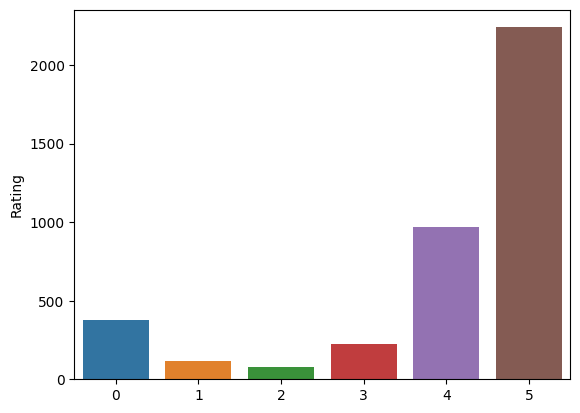

In [60]:
sns.barplot(x=df_reviews_cleaned.Rating.value_counts().index, y=df_reviews_cleaned.Rating.value_counts())

In [61]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X = df_reviews_cleaned[['AuthorId', 'RecipeId']]
y = df_reviews_cleaned['Rating']

X_res, y_res = ros.fit_resample(X, y)

df_resampled = pd.concat([X_res, y_res], axis=1)

# sort by rating
df_resampled = df_resampled.sort_values(by=['Rating'])

<Axes: title={'center': 'Rating Distribution'}, xlabel='Rating', ylabel='Count'>

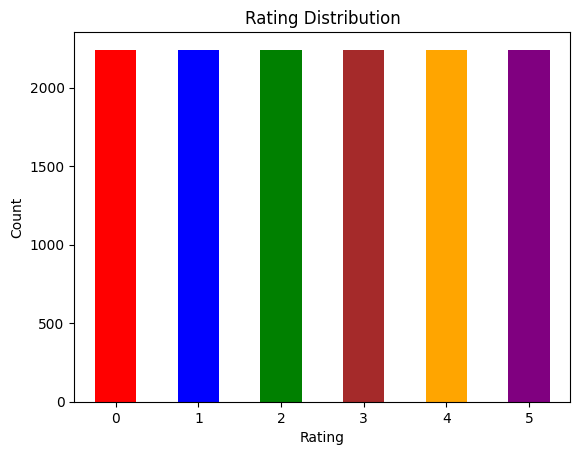

In [62]:
df_resampled['Rating'].value_counts().plot(kind='bar', color=['red', 'blue', 'green', 'brown', 'orange', 'purple'], title='Rating Distribution', rot=0, xlabel='Rating', ylabel='Count')

In [63]:
df_resampled.reset_index(drop=True, inplace=True)
df_resampled

,AuthorId,RecipeId,Rating
0,19569,11907,0
1,14532,11672,0
2,20869,13200,0
3,16305,13685,0
4,3504,4048,0
...,...,...,...
13441,20277,9272,5
13442,20966,9272,5
13443,18947,9272,5
13444,16140,9278,5


### Recipe Preprocessing

In [64]:
# use recipe that recipeId is in df_reviews_cleaned
df_recipes_filtered = df_recipes[df_recipes['RecipeId'].isin(df_reviews_cleaned['RecipeId'])]
df_recipes_filtered

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
6,44,Warm Chicken A La King,1596,Joan Edington,PT3M,PT35M,PT38M,1999-09-17T04:47:00Z,I copied this one out of a friend's book so ma...,"""https://img.sndimg.com/food/image/upload/w_55...",...,31.9,405.8,557.2,29.1,3.1,5.0,45.3,2.0,NaN,"c(""Melt 1 1/2 ozs butter, add the flour and co..."
24,62,"Black Bean, Corn, and Tomato Salad",1570,Dave Miner,PT15M,PT10M,PT25M,1999-08-19T05:12:00Z,"This is easy, delicious, colorful, delicious, ...",character(0),...,2.3,0.0,20.0,55.8,16.6,4.3,17.1,2.0,NaN,"c(""In a bowl whisk together lemon juice, oil, ..."
28,67,Bourbon Pecan Pound Cake,1573,benluc,PT1H,PT1H,PT2H,1999-09-01T09:01:00Z,Make and share this Bourbon Pecan Pound Cake r...,character(0),...,13.6,143.6,441.9,91.2,1.9,62.6,7.8,12.0,NaN,"c(""Combine butter and sugar in bowl of electri..."
33,72,Brownie Pudding,193853,MirandaLee,PT35M,PT40M,PT1H15M,1999-08-20T09:50:00Z,Make and share this Brownie Pudding recipe fro...,character(0),...,3.6,7.8,160.2,34.0,2.1,25.3,2.3,10.0,NaN,"c(""Preheat oven to 350 degrees."", ""Combine flo..."
43,83,Bubble and Squeak,1544,tranch,PT2H27M,PT30M,PT2H57M,1999-08-28T02:59:00Z,Make and share this Bubble and Squeak recipe f...,character(0),...,11.5,54.9,286.1,56.9,7.6,4.9,11.1,4.0,NaN,"c(""Wash potatoes under cold running water then..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65601,70137,Mexicali Spoon Bread Casserole,51579,SilentCricket,PT40M,PT30M,PT1H10M,2003-09-02T20:01:00Z,In the mood for something Mexican and/or cornb...,character(0),...,11.8,171.0,1392.1,34.2,4.3,6.4,32.8,NaN,1 casserole,"c(""Brown beef, onions, green pepper, and garli..."
103405,109055,Mediterranean Penne,148316,- Carla -,PT25M,PT20M,PT45M,2005-01-21T20:03:00Z,"I don't know how this recipe came to be, I've ...","c(""https://img.sndimg.com/food/image/upload/w_...",...,12.6,62.4,1381.2,50.6,8.9,5.1,15.1,6.0,NaN,"c(""In a large pot, cook penne according to pac..."
154014,161382,Island Mango Bread,217657,startnover,NaN,PT10M,PT10M,2006-03-24T15:55:00Z,Lots of flavors come together to make a yummy ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,41.0,431.8,4578.9,455.7,12.8,259.6,44.6,NaN,1 loaf,"c(""Mix sour cream and margarine together and t..."
154031,161399,Sweet Potato and Mango Bake,128473,Baby Kato,PT1H,PT30M,PT1H30M,2006-03-24T16:00:00Z,A nice side dish served with savoury chicken a...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,15.3,360.6,45.5,4.4,27.6,2.8,4.0,NaN,"c(""Preheat oven to 350°F."", ""Grease pan lightl..."


In [65]:
df_recipes_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2517 entries, 6 to 154041
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RecipeId                    2517 non-null   int64  
 1   Name                        2517 non-null   object 
 2   AuthorId                    2517 non-null   int64  
 3   AuthorName                  2517 non-null   object 
 4   CookTime                    1941 non-null   object 
 5   PrepTime                    2517 non-null   object 
 6   TotalTime                   2517 non-null   object 
 7   DatePublished               2517 non-null   object 
 8   Description                 2515 non-null   object 
 9   Images                      2517 non-null   object 
 10  RecipeCategory              2517 non-null   object 
 11  Keywords                    2492 non-null   object 
 12  RecipeIngredientQuantities  2517 non-null   object 
 13  RecipeIngredientParts       251

In [66]:
# drop unused columns
columns = ['AuthorId', 'AuthorName', 'Description', 'Images', 'CookTime', 'PrepTime', 'TotalTime', 'DatePublished', 'Images', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeYield', 'RecipeInstructions']
df_recipes_filtered = df_recipes_filtered.drop(columns, axis=1)
df_recipes_filtered

,RecipeId,Name,RecipeCategory,Keywords
6,44,Warm Chicken A La King,Chicken,"c(""Poultry"", ""Meat"", ""< 60 Mins"")"
24,62,"Black Bean, Corn, and Tomato Salad",Black Beans,"c(""Corn"", ""Beans"", ""Vegetable"", ""Low Cholester..."
28,67,Bourbon Pecan Pound Cake,Dessert,"c(""Fruit"", ""Nuts"", ""Weeknight"", ""Oven"", ""< 4 H..."
33,72,Brownie Pudding,Dessert,"c(""Low Protein"", ""Healthy"", ""Weeknight"", ""Oven..."
43,83,Bubble and Squeak,Breakfast,"c(""European"", ""Weeknight"", ""Broil/Grill"", ""Ove..."
...,...,...,...,...
65601,70137,Mexicali Spoon Bread Casserole,Oven,"c(""Stove Top"", ""< 4 Hours"")"
103405,109055,Mediterranean Penne,Penne,"c(""Cheese"", ""Vegetable"", ""European"", ""< 60 Mins"")"
154014,161382,Island Mango Bread,Quick Breads,"c(""Breads"", ""Breakfast"", ""Mango"", ""Tropical Fr..."
154031,161399,Sweet Potato and Mango Bake,Yam/Sweet Potato,"c(""Potato"", ""Vegetable"", ""< 4 Hours"")"


In [67]:
df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].str.replace('"', '')
df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].str.replace('c()', '')
df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].str.replace('(', '')
df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].str.replace(')', '')
df_recipes_filtered

/tmp/ipykernel_13189/3208247459.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].str.replace('c()', '')
/tmp/ipykernel_13189/3208247459.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].str.replace('(', '')
/tmp/ipykernel_13189/3208247459.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].str.replace(')', '')


,RecipeId,Name,RecipeCategory,Keywords
6,44,Warm Chicken A La King,Chicken,"Poultry, Meat, < 60 Mins"
24,62,"Black Bean, Corn, and Tomato Salad",Black Beans,"Corn, Beans, Vegetable, Low Cholesterol, Healt..."
28,67,Bourbon Pecan Pound Cake,Dessert,"Fruit, Nuts, Weeknight, Oven, < 4 Hours"
33,72,Brownie Pudding,Dessert,"Low Protein, Healthy, Weeknight, Oven, < 4 Hours"
43,83,Bubble and Squeak,Breakfast,"European, Weeknight, Broil/Grill, Oven, Stove ..."
...,...,...,...,...
65601,70137,Mexicali Spoon Bread Casserole,Oven,"Stove Top, < 4 Hours"
103405,109055,Mediterranean Penne,Penne,"Cheese, Vegetable, European, < 60 Mins"
154014,161382,Island Mango Bread,Quick Breads,"Breads, Breakfast, Mango, Tropial Fruits, Frui..."
154031,161399,Sweet Potato and Mango Bake,Yam/Sweet Potato,"Potato, Vegetable, < 4 Hours"


In [68]:
df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].fillna('')
df_recipes_filtered

,RecipeId,Name,RecipeCategory,Keywords
6,44,Warm Chicken A La King,Chicken,"Poultry, Meat, < 60 Mins"
24,62,"Black Bean, Corn, and Tomato Salad",Black Beans,"Corn, Beans, Vegetable, Low Cholesterol, Healt..."
28,67,Bourbon Pecan Pound Cake,Dessert,"Fruit, Nuts, Weeknight, Oven, < 4 Hours"
33,72,Brownie Pudding,Dessert,"Low Protein, Healthy, Weeknight, Oven, < 4 Hours"
43,83,Bubble and Squeak,Breakfast,"European, Weeknight, Broil/Grill, Oven, Stove ..."
...,...,...,...,...
65601,70137,Mexicali Spoon Bread Casserole,Oven,"Stove Top, < 4 Hours"
103405,109055,Mediterranean Penne,Penne,"Cheese, Vegetable, European, < 60 Mins"
154014,161382,Island Mango Bread,Quick Breads,"Breads, Breakfast, Mango, Tropial Fruits, Frui..."
154031,161399,Sweet Potato and Mango Bake,Yam/Sweet Potato,"Potato, Vegetable, < 4 Hours"


In [69]:
# find average rating and review count for each recipe from df_reviews_cleaned
# df_rating_average = df_reviews_cleaned.groupby(['RecipeId']).mean()
# df_rating_average = df_rating_average.reset_index()
# df_rating_average

# drop AuthorId column
# df_rating_average = df_rating_average.drop(['AuthorId'], axis=1)
# df_rating_average

In [70]:
# merge df_recipes_filtered and df_rating_average
# df_recipes_filtered = df_recipes_filtered.merge(df_rating_average, on='RecipeId')
# df_recipes_filtered = df_recipes_filtered.rename(columns={'Rating': 'AverageRating'})
# df_recipes_filtered


In [71]:
df_recipes_filtered.reset_index(drop=True, inplace=True)

### Hybrid Recommender System

#### Recipe recommender with TF-IDF

In [72]:
# use tfidf to vectorize recipe name, recipe category, and keywords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# recipe name
tfidf_recipe_name = TfidfVectorizer()
recipe_name_matrix = tfidf_recipe_name.fit_transform(df_recipes_filtered['Name'])
recipe_name_matrix.shape

(2517, 2018)

In [73]:
# recipe category
tfidf_recipe_category = TfidfVectorizer()
recipe_category_matrix = tfidf_recipe_category.fit_transform(df_recipes_filtered['RecipeCategory'])
recipe_category_matrix.shape


(2517, 180)

In [74]:
# keywords
tfidf_keywords = TfidfVectorizer()
keywords_matrix = tfidf_keywords.fit_transform(df_recipes_filtered['Keywords'])
keywords_matrix.shape

(2517, 230)

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
recipe_name_matrix_scaled = scaler.fit_transform(recipe_name_matrix)
recipe_category_matrix_scaled = scaler.fit_transform(recipe_category_matrix)
keywords_matrix_scaled = scaler.fit_transform(keywords_matrix)

In [76]:
# combine all matrices
from scipy.sparse import hstack

combined_matrix = hstack([recipe_name_matrix, recipe_category_matrix, keywords_matrix])
combined_matrix.shape

(2517, 2428)

In [77]:
# calculate cosine similarity
cosine_sim = cosine_similarity(combined_matrix, combined_matrix)
cosine_sim.shape

(2517, 2517)

In [78]:
# create a Series for recipe names
indices = pd.Series(df_recipes_filtered.index, index=df_recipes_filtered['Name']).drop_duplicates()
indices

Name
Warm Chicken A La King                               0
Black Bean, Corn, and Tomato Salad                   1
Bourbon Pecan Pound Cake                             2
Brownie Pudding                                      3
Bubble and Squeak                                    4
                                                  ... 
Mexicali Spoon Bread Casserole                    2512
Mediterranean Penne                               2513
Island Mango Bread                                2514
Sweet Potato and Mango Bake                       2515
Grilled Lime-Cilantro Chicken With Mango Salsa    2516
Length: 2517, dtype: int64

In [79]:
def get_recommendations(name, cosine_sim=cosine_sim):
    # get index of recipe that matches name
    idx = indices[name]

    # get similarity scores of all recipes with that recipe
    sim_scores = list(enumerate(cosine_sim[idx]))

    # sort recipes based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # get top 20 similar recipes
    sim_scores = sim_scores[1:21]

    # get recipe indices and scores
    recipe_indices = [i[0] for i in sim_scores]
    similarity_scores = [i[1] for i in sim_scores]
    
    similar_recipes = df_recipes_filtered['Name'].iloc[recipe_indices]
    return similar_recipes, similarity_scores


In [80]:
name = 'Pumpkin Pie'
recommendations, scores = get_recommendations(name)
for recipe, score in zip(recommendations, scores):
    print(f"Recipe: {recipe}, Similarity Score: {score}")

Recipe: Praline Pumpkin Pie, Similarity Score: 0.8343143014741122
Recipe: Boozy Pumpkin Pie, Similarity Score: 0.7720221443004465
Recipe: Pumpkin Pie Crunch, Similarity Score: 0.7651591460640256
Recipe: Pumpkin Squares, Similarity Score: 0.7106279016053639
Recipe: Cranberry Pie, Similarity Score: 0.6828336936737822
Recipe: Pumpkin Ice Cream Pie, Similarity Score: 0.6520744235319138
Recipe: Decadent Apple Pie, Similarity Score: 0.651633287912842
Recipe: Chocolate Turtle Pie, Similarity Score: 0.6404778335683231
Recipe: Top Rated Pecan Pie, Similarity Score: 0.6314747404082172
Recipe: Chocolate Pie, Similarity Score: 0.6280915464718332
Recipe: oreo cream pie, Similarity Score: 0.6174697267846176
Recipe: Kentucky Apple Festival Apple Pie, Similarity Score: 0.5961939320856887
Recipe: Bishop Pie, Similarity Score: 0.5920203657019747
Recipe: Decadent Triple Layer Mud Pie, Similarity Score: 0.5889063318391938
Recipe: Chocolate Chip Pie, Similarity Score: 0.586227229218564
Recipe: White Chocol

#### Collaborative filtering

##### SVD

In [81]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms.knns import KNNBasic

In [85]:
# parsing data rating
reader = Reader(rating_scale=(1, 5))

# load dataset
data = Dataset.load_from_df(df_resampled[['AuthorId', 'RecipeId', 'Rating']], reader)

In [86]:
train, test = train_test_split(data, test_size=0.2)

In [104]:
SVD_model = SVD()
SVD_model.fit(train)

In [105]:
results = cross_validate(SVD_model, data, measures=['RMSE', 'MSE'], cv=10, verbose=True) 

1.1027534607674634
{'n_epochs': 15, 'lr_all': 0.005, 'reg_all': 0.4}


In [106]:
print('Best fold: ', results['test_rmse'].argmin(axis=0) + 1)
print('RMSE: ', results['test_rmse'].min(axis=0))
print('MSE: ', results['test_mse'].min(axis=0))

In [108]:
def getUserRatingres(user_id, num_recommendations):
    all_item_ids = train.all_items()

    for recipe_id in all_item_ids:
        temp = SVD_model.predict(user_id, recipe_id)

    predictions = [SVD_model.predict(user_id, recipe_id) for recipe_id in all_item_ids]
    predictions.sort(key=lambda x: x.est, reverse=True)
    top_recommendations = predictions[:num_recommendations]
    recommended_recipe_ids = [int(prediction.iid) for prediction in top_recommendations]

    print(f"Top {num_recommendations} recommended recipes for user {user_id}: {recommended_recipe_ids}")

In [111]:
# get top 10 recommended recipes for user from df_resampled
random_user = df_resampled['AuthorId'].sample(n=1).values[0]
getUserRatingres(random_user, 10)

Top 10 recommended recipes for user 11797: [2086, 834, 566, 607, 249, 1809, 451, 155, 542, 131]


##### KNN Basic

In [88]:
param_grid = {'k': [10, 20, 30, 40, 50],
              'min_k': [1, 2, 3, 4, 5],
              'sim_options': {'name': ['msd', 'pearson_baseline'],
                              'user_based': [False, True]}
             }

gs_knn = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5)
gs_knn.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Compu

In [89]:
print(gs_knn.best_score['rmse'])
print(gs_knn.best_params['rmse'])

1.1172613385198733
{'k': 10, 'min_k': 1, 'sim_options': {'name': 'msd', 'user_based': False}}


In [90]:
best_model = KNNBasic(k=gs_knn.best_params['rmse']['k'],
                      min_k=gs_knn.best_params['rmse']['min_k'],
                      sim_options=gs_knn.best_params['rmse']['sim_options'])

In [91]:
trainset = data.build_full_trainset()
best_model.fit(train)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [92]:
def predict_rating(user_id, item_id):
    print(f"{user_id} rate {item_id}: {best_model.predict(user_id, item_id).est}")

In [94]:
random_user = df_resampled['AuthorId'].sample(n=1).values[0]
random_item = df_resampled['RecipeId'].sample(n=1).values[0]
predict_rating(random_user, random_item)

17803 rate 10075: 2.508181480104128


#### Matrix Factorization